<a href="https://colab.research.google.com/github/enriquecorimayo/Doctorado/blob/main/QLBSwithSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install QuantLib
!pip install bspline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import QuantLib as ql
import sys

sys.path.append("..")

import time
import matplotlib.pyplot as plt
import gc


## Parameters for MC simulation of stock prices

In [ ]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity
T = 10        # number of time steps
K = 100 #Strike

N_MC = 12000 # 10000 # 50000   # number of paths
risk_lambda = 0.001 # 0.001 # 0.0001            # risk aversion

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

Based on simulated stock price $S_t$ paths, compute state variable $X_t$ by the following relation.

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

Also compute

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

where $\Delta\bar{S}_t$ is the sample mean of all values of $\Delta S_t$.

Plots of 5 stock price $S_t$ and state variable $X_t$ paths are shown below.


Time Cost: 0.05316591262817383 seconds


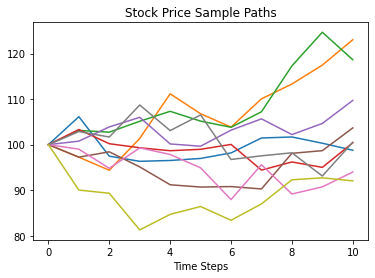

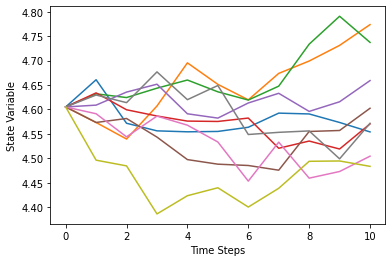

In [ ]:
# make a dataset 

starttime = time.time()
np.random.seed(42) # Fix random seed
# stock price
S_BS = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_BS.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S_BS.loc[:,t] = S_BS.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S_BS = S_BS.loc[:,1:T].values - np.exp(r * delta_t) * S_BS.loc[:,0:T-1]
delta_S_hat_BS = delta_S_BS.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X_BS = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_BS)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S_BS.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X_BS.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

### Merton76 (Jump Diffusion) Simulation


In [ ]:
# stock price
S_M76 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_M76.loc[:,0] = S0



Time Cost: 0.4745776653289795 seconds


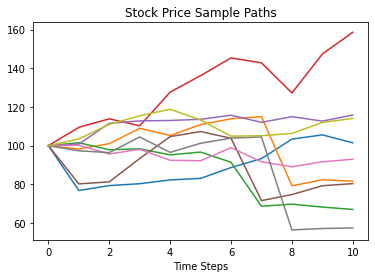

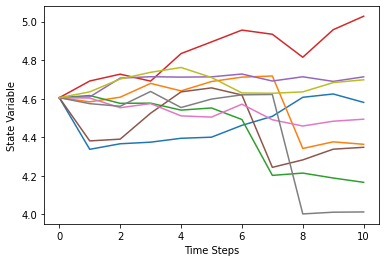

In [ ]:
def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths+1)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S
m = -0.1 # meean of jump size
v = 0.3 # standard deviation of jump
lam =1 # intensity of jump i.e. number of jumps per annum

jumpDiffusionPaths = merton_jump_paths(S0, M, r, sigma, lam, m, v, T, N_MC-1)
S_M76.loc[:,1:] = np.transpose(jumpDiffusionPaths)

# state variable
X_M76 = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_M76)   # delta_t here is due to their conventions

delta_S_M76 = S_M76.loc[:,1:T].values - np.exp(r * delta_t) * S_M76.loc[:,0:T-1]
delta_S_hat_M76 = delta_S_M76.apply(lambda x: x - np.mean(x), axis=0)

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S_M76.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X_M76.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

In [ ]:
S_M76

,0,1,2,3,4,5,6,7,8,9,10
1,100,104.492178,107.504722,104.804370,99.417837,98.955612,100.537615,103.014322,102.158120,111.349388,114.069179
2,100,109.667117,146.615306,143.256234,138.876599,134.634073,124.769646,130.220880,124.546367,115.047593,115.256925
3,100,140.791030,153.326008,149.057872,146.211144,136.698671,142.767276,146.269912,146.699011,150.519549,160.725053
4,100,100.953338,102.977885,111.449401,115.190288,122.893003,114.607897,115.612263,125.751623,158.389930,155.848239
5,100,107.479476,102.102856,102.035906,102.665283,104.705247,117.179012,124.914607,120.014730,122.252683,124.560658
...,...,...,...,...,...,...,...,...,...,...,...
11996,100,94.160028,107.755139,109.239734,111.156297,116.694709,105.130927,112.284040,109.349191,107.013989,102.963003
11997,100,101.951068,108.954576,122.015703,126.489994,124.470322,198.015786,200.995961,200.224571,213.148613,207.294347
11998,100,97.161914,92.147979,89.348968,84.726431,79.527795,77.853701,72.954805,69.482220,72.977985,71.480795
11999,100,99.001863,100.671642,104.324326,94.755039,70.963236,76.006892,78.417007,75.019420,75.275821,73.542031


###Heston Model Simulation

In [ ]:
def generate_multi_paths_df(seq, num_paths, steps):
    spot_paths = []
    vol_paths = []

    for i in range(num_paths):
        sample_path = seq.next()
        values = sample_path.value()

        spot, vol = values

        spot_paths.append([x for x in spot])
        vol_paths.append([x for x in vol])

    df_spot = pd.DataFrame(spot_paths, index=range(1, N_MC+1),columns=range(steps+1))
    df_vol = pd.DataFrame(vol_paths, index=range(1, N_MC+1),columns=range(steps+1))

    return df_spot, df_vol

In [ ]:
today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.00, ql.Actual365Fixed()))

initialValue = ql.QuoteHandle(ql.SimpleQuote(S0))

v0 = 0.005
kappa = 0.8
theta = 0.008
rho = 0.2

hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, v0, kappa, theta, sigma, rho)

In [ ]:
times = ql.TimeGrid(M, T)

dimension = hestonProcess.factors()

rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(dimension * T, ql.UniformRandomGenerator())
)
seq = ql.GaussianMultiPathGenerator(hestonProcess, list(times), rng, False)

df_spot,df_vol = generate_multi_paths_df(seq, N_MC,T)


Time Cost: 1.999537467956543 seconds


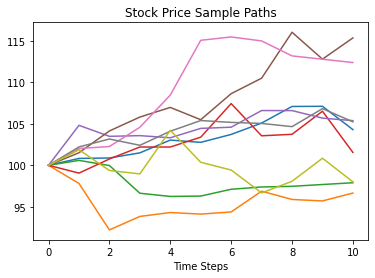

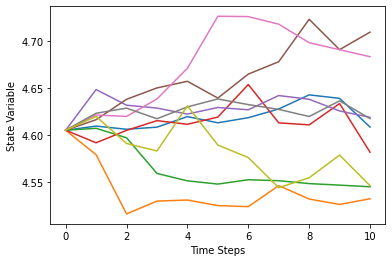

In [ ]:
# Heston df
S_Heston = df_spot
# state variable
X_Heston = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_Heston)   # delta_t here is due to their conventions

delta_S_Heston = S_Heston.loc[:,1:T].values - np.exp(r * delta_t) * S_Heston.loc[:,0:T-1]
delta_S_hat_Heston = delta_S_Heston.apply(lambda x: x - np.mean(x), axis=0)

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S_Heston.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X_Heston.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

Define function *terminal_payoff* to compute the terminal payoff of a European put option.

$$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [ ]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K-ST, 0)
    return payoff

###Select the process

In [ ]:
X = X_BS
S = S_BS
delta_S = delta_S_BS
delta_S_hat = delta_S_BS

In [ ]:
del X_Heston, S_Heston, delta_S_Heston, delta_S_hat_Heston

In [ ]:
del X_M76, S_M76, delta_S_M76, delta_S_hat_M76

##  Define spline basis functions


X.shape =  (12000, 11)
X_min, X_max =  4.050393734126806 5.181737500561616
Number of points k =  25


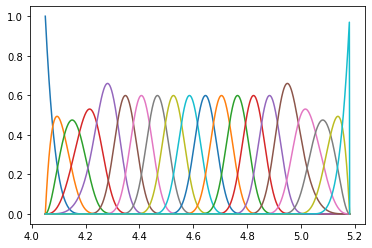

<Figure size 432x288 with 0 Axes>

In [ ]:
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = T*2

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
f = plt.figure()

# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [ ]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

# fill it, expand function in finite dimensional space
# in neural network the basis is the neural network itself
t_0 = time.time()
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])
 
t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  20
dim data_mat_t =  (11, 12000, 20)
Computational time: 17.215935945510864 seconds


In [ ]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)

In [ ]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(11, 12000, 20)
25


## Dynamic Programming solution for QLBS 

The MDP problem in this case is to solve the following Bellman optimality equation for the action-value function.

$$Q_t^\star\left(x,a\right)=\mathbb{E}_t\left[R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\space|\space X_t=x,a_t=a\right],\space\space t=0,...,T-1,\quad\gamma=e^{-r\Delta t}$$

where $R_t\left(X_t,a_t,X_{t+1}\right)$ is the one-step time-dependent random reward and $a_t\left(X_t\right)$ is the action (hedge).

Detailed steps of solving this equation by Dynamic Programming are illustrated below.

With this set of basis functions $\left\{\Phi_n\left(X_t^k\right)\right\}_{n=1}^N$, expand the optimal action (hedge) $a_t^\star\left(X_t\right)$ and optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ in basis functions with time-dependent coefficients.
$$a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$$

Coefficients $\phi_{nt}$ and $\omega_{nt}$ are computed recursively backward in time for $t=T−1,...,0$. 

Coefficients for expansions of the optimal action $a_t^\star\left(X_t\right)$ are solved by

$$\phi_t=\mathbf A_t^{-1}\mathbf B_t$$

where $\mathbf A_t$ and $\mathbf B_t$ are matrix and vector respectively with elements given by

$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$

Define function *function_A* and *function_B* to compute the value of matrix $\mathbf A_t$ and vector $\mathbf B_t$.

##Implement functions to compute optimal hedges

In [ ]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """
    data_mat_t = data_mat[t, :, :]
    num_basis = data_mat_t.shape[1]
    delta_S_hat_t = delta_S_hat.loc[:, t]
    delta_S_hat_t = (delta_S_hat_t ** 2).values.reshape(-1, 1)
    A_mat = np.dot(data_mat_t.T, data_mat_t * delta_S_hat_t) + reg_param * np.eye(num_basis)
    return A_mat

def function_B_vec(t,
                   Pi_hat, 
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    
    Return:
    B_vec - np.array() of dimension num_basis x 1
    """
    coef = 0. # keep it
    data_mat_t = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(data_mat_t.T, Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t])
  
    return B_vec

## Compute optimal hedge and portfolio value

Call *function_A* and *function_B* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action $a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $a_T^\star\left(X_T\right)=0$.

Once the optimal hedge $a_t^\star\left(X_t\right)$ is computed, the portfolio value $\Pi_t$ could also be computed backward recursively by 

$$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$

together with the terminal condition $\Pi_T=H_T\left(S_T\right)=\max\left(K-S_T,0\right)$ for a European put option.

Also compute $\hat{\Pi}_t=\Pi_t-\bar{\Pi}_t$, where $\bar{\Pi}_t$ is the sample mean of all values of $\Pi_t$.

In [ ]:
starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3


In [ ]:
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')

Computational time: 0.14282560348510742 seconds


## Hedging and Pricing with Reinforcement Learning

Implement a batch-mode off-policy model-free Q-Learning by Fitted Q-Iteration. 

---

The only data available is given by a set of $N_{MC}$ paths for the underlying state variable $X_t$, hedge position $a_t$, instantaneous reward $R_t$ and the next-time value $X_{t+1}$.

$$\mathcal F_t^k=\left\{\left(X_t^k,a_t^k,R_t^k,X_{t+1}^k\right)\right\}_{t=0}^{T-1}\quad k=1,...,N_{MC}$$

Detailed steps of solving the Bellman optimalty equation by Reinforcement Learning are illustrated below.

Expand Q-function in basis functions with time-dependent coefficients parametrized by a matrix $\mathbf W_t$.

$$Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf W_t\Phi\left(X_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)=\vec{W}_t^T \vec{\Psi}\left(X_t,a_t\right)$$

$$\mathbf A_t=\left(\begin{matrix}1\\a_t\\\frac{1}{2}a_t^2\end{matrix}\right)\quad\mathbf U_W\left(t,X_t\right)=\mathbf W_t\Phi\left(X_t\right)$$

where $\vec{W}_t$ is obtained by concatenating columns of matrix $\mathbf W_t$ while 
$ vec \left( {\bf \Psi} \left(X_t,a_t \right) \right) = 
  vec \, \left( {\bf A}_t  \otimes {\bf \Phi}^T(X) \right) $ stands for 
a vector obtained by concatenating columns of the outer product of vectors $ {\bf A}_t $ and $ {\bf \Phi}(X) $.

Compute vector $\mathbf A_t$ then compute $\vec\Psi\left(X_t,a_t\right)$ for each $X_t^k$ and store in a dictionary with key path and time $\left[k,t\right]$.

## Part 3: Make off-policy data

- **on-policy** data - contains an optimal action and the corresponding reward
- **off-policy** data - contains random action and the corresponding reward

Given a large enough sample, i.e. N_MC tending to infinity Q-Learner will learn an optimal policy from the data in a model-free setting.
In our case a random action is an optimal action + noise generated by sampling from uniform: distribution $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$

where $\eta$ is a disturbance level
In other words, each noisy action is calculated by taking optimal action computed previously and multiplying it by a uniform r.v. in the interval $\left[1-\eta, 1 + \eta\right]$

**Instructions:**
In the loop below:
 - Compute the optimal policy, and write the result to a_op
 - Now disturb these values by a random noise
 $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$
 - Compute portfolio values corresponding to observed actions
 $$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$
 - Compute rewards corrresponding to observed actions
 $$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=T-1,...,0$$
with terminal condition $$R_T=-\lambda Var\left[\Pi_T\right]$$

In [ ]:
eta = 0.5 #  0.5 # 0.25 # 0.05 # 0.5 # 0.1 # 0.25 # 0.15
reg_param = 1e-3
np.random.seed(42) # Fix random seed

# disturbed optimal actions to be computed 
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# also make portfolios and rewards
# portfolio value
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):
    
    ### START CODE HERE ### (≈ 11-12 lines of code)
    
    # 1. Compute the optimal policy, and write the result to a_op
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a_op.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    # 2. Now disturb these values by a random noise
    a_op.loc[:,t] = a_op.loc[:,t]*np.random.uniform(1-eta,1+eta,size=a_op.shape[0])
    # 3. Compute portfolio values corresponding to observed actions
    Pi_op.loc[:,t]= gamma*(Pi_op.loc[:, t+1]-a_op.loc[:,t]* delta_S.loc[:,t])
    # TODO: Review the line below, in the Coursera Notebook is different...
    Pi_op_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
    # 4. Compute rewards corrresponding to observed actions
    R_op.loc[1:,t] = gamma * a_op.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi_op.loc[1:,t])
    ### END CODE HERE ###
  
print('done with backward loop!')

done with backward loop!


In [ ]:
a = a_op.copy()      # distrubed actions
Pi = Pi_op.copy()    # disturbed portfolio values
Pi_hat = Pi_op_hat.copy()
R = R_op.copy()

In [ ]:
# make matrix A_t of shape (3 x num_MC x num_steps)
num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

print(A_stack.shape)

(3, 12000, 11)


In [ ]:
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

print(data_mat_swap_idx.shape) # (12, 10000, 25)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,10000,25)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,10000,25)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
# Psi_mat = Psi_mat.reshape(-1, a.shape[0], a.shape[1], order='F')
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

print(Psi_mat.shape) #

(20, 12000, 11)
(60, 12000, 11)


In [ ]:
del data_mat_swap_idx, A_2

In [ ]:
gc.collect()

110

In [ ]:
# # make matrix S_t 

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)
print(Psi_1_aux.nbytes, Psi_2_aux.nbytes)

S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) 

print(S_t_mat.shape)
print(S_t_mat.nbytes)

(60, 1, 12000, 11) (1, 60, 12000, 11)
63360000 63360000
(60, 60, 11)
316800


In [ ]:
# clean up some space
del Psi_1_aux, Psi_2_aux, 


## Part 4: Calculate $\mathbf S_t$ and $\mathbf M_t$ marix and vector
Vector $\vec W_t$ could be solved by

$$\vec W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\Psi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\left(R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

**Instructions:**
- implement function_S_vec() which computes $S_{nm}^{\left(t\right)}$ matrix
- implement function_M_vec() which computes $M_n^{\left(t\right)}$ column vector

In [ ]:
# vectorized functions

def function_S_vec(t, S_t_mat, reg_param):
    """
    function_S_vec - calculate S_{nm} matrix from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t - time index, a scalar, an index into time axis of S_t_mat 
    S_t_mat - pandas.DataFrame of dimension num_Qbasis x num_Qbasis x T
    reg_param - regularization parameter, a scalar
    Return:
    S_mat_reg - num_Qbasis x num_Qbasis
    """

    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param*np.eye(num_Qbasis)
    return S_mat_reg
   
def function_M_vec(t,
                   Q_star, 
                   R, 
                   Psi_mat_t, 
                   gamma=gamma):
    """
    function_S_vec - calculate M_{nm} vector from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t- time index, a scalar, an index into time axis of S_t_mat 
    Q_star - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    Psi_mat_t - pandas.DataFrame of dimension num_Qbasis x N_MC
    gamma - one time-step discount factor $exp(-r \delta t)$
    Return:
    M_t - np.array of dimension num_Qbasis x 1
    """

    term = R.loc[:,t] + gamma*Q_star.loc[:,t+1]
    M_t = np.dot(Psi_mat_t, term)

    return M_t

Call *function_S* and *function_M* for $t=T-1,...,0$ together with vector $\vec\Psi\left(X_t,a_t\right)$ to compute $\vec W_t$ and learn the Q-function $Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)$ implied by the input data backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

When the vector $ \vec{W}_t $ is computed as per the above at time $ t $, 
we can convert it back to a matrix $ \bf{W}_t $ obtained from the vector $ \vec{W}_t $ by 
reshaping to the shape $ 3 \times M $.

We can now calculate the matrix $ {\bf U}_t $
at time $ t $ for the whole set of MC paths as follows (this is Eq.(65) from the paper in a matrix form):

$$  \mathbf U_{W} \left(t,X_t \right) = 
\left[\begin{matrix} \mathbf U_W^{0,k}\left(t,X_t \right) \\  
\mathbf U_W^{1,k}\left(t,X_t \right) \\ \mathbf U_W^{2,k} \left(t,X_t \right)
\end{matrix}\right]
= \bf{W}_t \Phi_t \left(t,X_t \right)  $$

Here the matrix $ {\bf \Phi}_t $ has the shape shape $ M \times N_{MC}$. 
Therefore, their dot product has dimension $ 3 \times N_{MC}$, as it should be. 

Once this matrix $ {\bf U}_t $ is computed, individual vectors $ {\bf U}_{W}^{1}, {\bf U}_{W}^{2}, {\bf U}_{W}^{3} $ for all MC paths are read off as rows of this matrix.

From here, we can compute the optimal action and optimal Q-function $Q^{\star}(X_t, a_t^{\star}) $ at the optimal action for a given step $ t $. This will be used to evaluate the $ \max_{a_{t+1} \in \mathcal{A}} Q^{\star} \left(X_{t+1}, a_{t+1} \right) $.


The optimal action and optimal Q-function with the optimal action could be computed by

$$a_t^\star\left(X_t\right)=\frac{\mathbb{E}_{t} \left[  \Delta \hat{S}_{t}  \hat{\Pi}_{t+1} + \frac{1}{2 \gamma \lambda} \Delta S_{t} \right]}{
  \mathbb{E}_{t} \left[ \left( \Delta \hat{S}_{t} \right)^2 \right]}\, , 
\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\mathbf U_W^{\left(0\right)}\left(t,X_t\right)+ a_t^\star \mathbf U_W^{\left(2\right)}\left(t,X_t\right) +\frac{1}{2}\left(a_t^\star\right)^2\mathbf U_W^{\left(2\right)}\left(t,X_t\right)$$

with terminal condition $a_T^\star=0$ and $Q_T^\star\left(X_T,a_T^\star=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

Plots of 5 optimal action $a_t^\star\left(X_t\right)$, optimal Q-function with optimal action $Q_t^\star\left(X_t,a_t^\star\right)$ and implied Q-function $Q_t^\star\left(X_t,a_t\right)$ paths are shown below.

## Fitted Q Iteration (FQI)

In [ ]:
starttime = time.time()

# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

# max_Q_star_next = Q_star.iloc[:,-1].values 
max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

# The backward loop
for t in range(T-1, -1, -1):
    
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M 
        
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

    # compute matrix U_mat of dimension N_MC x 3 
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    # IMPORTANT!!! Instead, use hedges computed as in DP approach:
    # in this way, errors of function approximation do not back-propagate. 
    # This provides a stable solution, unlike
    # the first method that leads to a diverging solution 
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)
    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 

    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    
    # update dataframes     
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # print('t = %s low_perc_Q_RL = %s up_perc_Q_RL = %s' % (t, low_perc_Q_RL, up_perc_Q_RL))
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
    
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 0.15717363357543945 seconds


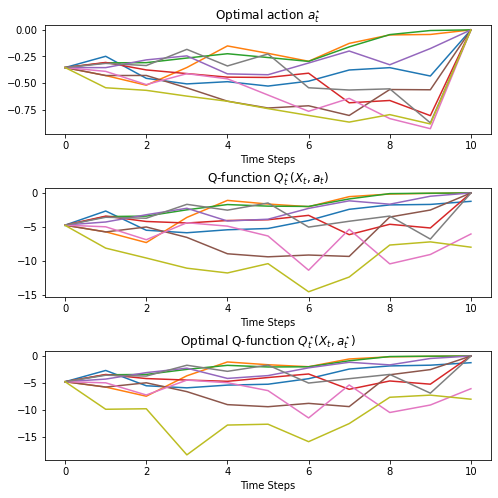

In [ ]:
# plot both simulations
f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()

In [ ]:
# The Black-Scholes prices
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

In [ ]:
# QLBS option price
C_QLBS = - Q_RL.copy() # Q_RL # 

print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nThe QLBS Put Price 1 :', (np.mean(C_QLBS.iloc[:,0]))))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_put(0)))
print('\n')

# # plot one path
# plt.plot(C_QLBS.T.iloc[:,[200]])
# plt.xlabel('Time Steps')
# plt.title('QLBS RL Option Price')
# plt.show()

---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.03
Risk aversion parameter : 0.001
Strike:                   100
Maturity:                 1

The QLBS Put Price 1 :    4.7799

Black-Sholes Put Price:   4.5296


